In [22]:
import numpy as np
import pandas as pd
import torch as torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [23]:
transform=transforms.Compose([transforms.ToTensor()])#transforms.compose is like pipeline it performs given list of transformations one by one.

In [24]:
train_data=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

Files already downloaded and verified


In [25]:
test_data=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

Files already downloaded and verified


In [26]:
train_image=torch.zeros(25000,3,32,32)
train_label=torch.zeros(25000)
test_image=torch.zeros(5000,3,32,32)
test_label=torch.zeros(5000)

In [27]:
i=0
for tuple in train_data:
    if(tuple[1]<5):
        train_image[i]=tuple[0]
        train_label[i]=tuple[1]
        i+=1

In [28]:
i=0
for tuple in test_data:
    if(tuple[1]<5):
        test_image[i]=tuple[0]
        test_label[i]=tuple[1]
        i+=1

In [29]:
print(train_image[0].shape,train_label[0],test_image[0].shape,test_label[0])

torch.Size([3, 32, 32]) tensor(4.) torch.Size([3, 32, 32]) tensor(3.)


In [30]:
train_label=train_label.type(torch.int64)
test_label=test_label.type(torch.int64)

In [31]:
class layer(nn.Module):
  def __init__(self,input,output):
    super().__init__()
    self.layer=nn.Linear(input,output)
  def forward(self,x,activation=True):
    if(activation):
      return F.leaky_relu(self.layer(x))
    else:
      return self.layer(x)

In [32]:
class Convolution(nn.Module):
  def __init__(self,input_channels,output_channels,kernel_y,kernel_x,stride_y,stride_x,padding_y,padding_x):
    super().__init__()
    self.convolve=nn.Conv2d(input_channels,output_channels,kernel_size=(kernel_y,kernel_x),stride=(stride_y,stride_x),padding=(padding_y,padding_x))

  def forward(self,x):
    return self.convolve(x)

In [33]:
class channel_block(nn.Module):
  def __init__(self,batch_size,no_channels,kernel_y,kernel_x,r):
    super().__init__()
    self.batch_size=batch_size
    self.no_channels=no_channels
    self.maxpool=nn.MaxPool2d(kernel_size=(kernel_y,kernel_x),stride=(kernel_y,kernel_x))
    self.avgpool=nn.AvgPool2d(kernel_size=(kernel_y,kernel_x),stride=(kernel_y,kernel_x))
    self.input=layer(no_channels,no_channels//r)
    self.output=layer(no_channels//r,no_channels)
  def forward(self,x):
    pool1=self.maxpool(x)
    pool2=self.avgpool(x)
    pool1=pool1.reshape(self.batch_size,self.no_channels)
    pool2=pool2.reshape(self.batch_size,self.no_channels)
    hidden1=self.input.forward(pool1)
    output1=self.output.forward(hidden1,False)
    hidden2=self.input.forward(pool2)
    output2=self.output.forward(hidden2,False)
    output=F.sigmoid(torch.add(output1,output2))
    z=torch.zeros(x.shape,device=device)
    for i,j in enumerate(x):
      for k,l in enumerate(j):
        z[i][k]=torch.mul(l,output[i][k])
    return z

In [34]:
class spatial_block(nn.Module):
  def __init__(self,no_channels):
    super().__init__()
    self.maxpool=nn.MaxPool3d(kernel_size=(no_channels,1,1),stride=(no_channels,1,1))
    self.avgpool=nn.AvgPool3d(kernel_size=(no_channels,1,1),stride=(no_channels,1,1))
    self.convolution=Convolution(2,1,5,5,1,1,2,2)
  def forward(self,x):
    pool1=self.maxpool(x)
    pool2=self.avgpool(x)
    pool_net=torch.cat([pool1,pool2],dim=1)
    output=F.sigmoid(self.convolution(pool_net))
    z=torch.zeros(x.shape,device=device)
    for i,j in enumerate(x):
      for k,l in enumerate(j):
        z[i][k]=torch.mul(l,output[i][0])
    return z


In [35]:
class Main(nn.Module):
  def __init__(self):
    super().__init__()

    ##Feature extraction layer(Convolution architecture)

    self.convolution1=Convolution(3,64,3,3,1,1,0,0)
    #3*32*32->64*30*30
    self.channel_block1=channel_block(16,64,30,30,8)
    #size does not changes in channel_block
    self.spatial_block1=spatial_block(64)
    #size does not changes in spatial_block
    self.maxpool1=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    #64*30*30->64*15*15
    self.bnorm1 = nn.BatchNorm2d(64)
    self.convolution2=Convolution(64,128,3,3,1,1,0,0)
    #64*15*15->128*13*13
    self.channel_block2=channel_block(16,128,13,13,16)
    #size does not changes in channel_block
    self.spatial_block2=spatial_block(128)
    #size does not changes in spatial_block
    self.maxpool2=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    #128*13*13->128*6*6
    self.bnorm2 = nn.BatchNorm2d(128)
    self.convolution3=Convolution(128,256,3,3,1,1,0,0)
    #128*6*6->256*4*4
    self.maxpool3=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    #128*4*4->256*2*2


    ##Fully connected layer

    self.input_layer=layer(256*2*2,128)
    self.hidden1=layer(128,64)
    self.output_layer=layer(64,10)

  def forward(self,x):
    convolve1=self.convolution1.forward(x)
    channel1=self.channel_block1.forward(convolve1)
    spatial1=self.spatial_block1.forward(channel1)
    pool1=self.maxpool1(spatial1)

    convolve2=self.convolution2.forward(self.bnorm1(pool1))
    channel2=self.channel_block2.forward(convolve2)
    spatial2=self.spatial_block2.forward(channel2)
    pool2=self.bnorm2(self.maxpool2(spatial2))

    convolve3=self.convolution3.forward(pool2)
    pool3=self.maxpool3(convolve3)

    input=pool3.reshape(16,256*2*2)
    hidden1=F.leaky_relu(self.input_layer.forward(input))
    hidden2=F.leaky_relu(self.hidden1.forward(hidden1))
    output=self.output_layer.forward(hidden2)

    return output

In [36]:
object=Main()

In [37]:
device='cpu'

In [38]:
object.load_state_dict(torch.load('epoch10Batch1562.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [39]:
for i in object.state_dict():
    print(i)

convolution1.convolve.weight
convolution1.convolve.bias
channel_block1.input.layer.weight
channel_block1.input.layer.bias
channel_block1.output.layer.weight
channel_block1.output.layer.bias
spatial_block1.convolution.convolve.weight
spatial_block1.convolution.convolve.bias
bnorm1.weight
bnorm1.bias
bnorm1.running_mean
bnorm1.running_var
bnorm1.num_batches_tracked
convolution2.convolve.weight
convolution2.convolve.bias
channel_block2.input.layer.weight
channel_block2.input.layer.bias
channel_block2.output.layer.weight
channel_block2.output.layer.bias
spatial_block2.convolution.convolve.weight
spatial_block2.convolution.convolve.bias
bnorm2.weight
bnorm2.bias
bnorm2.running_mean
bnorm2.running_var
bnorm2.num_batches_tracked
convolution3.convolve.weight
convolution3.convolve.bias
input_layer.layer.weight
input_layer.layer.bias
hidden1.layer.weight
hidden1.layer.bias
output_layer.layer.weight
output_layer.layer.bias


In [40]:
conv1_output=object.convolution1.forward(train_image[24991])

In [41]:
conv1_output.shape

torch.Size([64, 30, 30])

In [42]:
import matplotlib.pyplot as plt

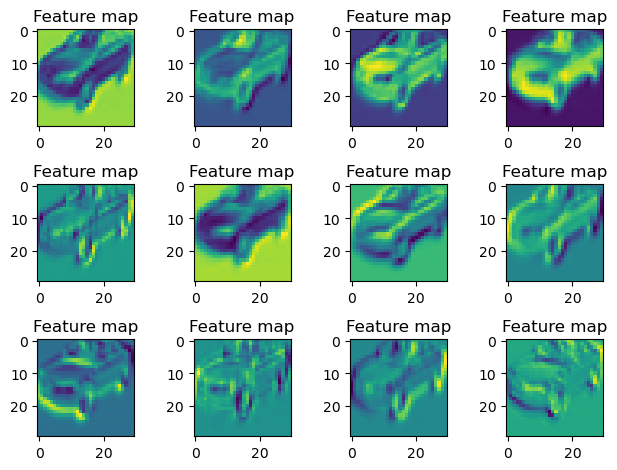

In [43]:
fig,axs=plt.subplots(3,4)
for i in range(3*4):
    axs[i//4][i%4].imshow(conv1_output[i].detach())
    axs[i//4][i%4].set_title("Feature map")
    #plt.tight_layout()
plt.tight_layout()

In [44]:
pool1=F.max_pool2d(conv1_output,kernel_size=(30,30)).reshape(64)
pool2=F.avg_pool2d(conv1_output,kernel_size=(30,30)).reshape(64)

In [45]:
print(pool1.shape,pool2.shape)

torch.Size([64]) torch.Size([64])


In [46]:
channel1_attention=object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))

In [47]:
channel1_attention.shape

torch.Size([64])

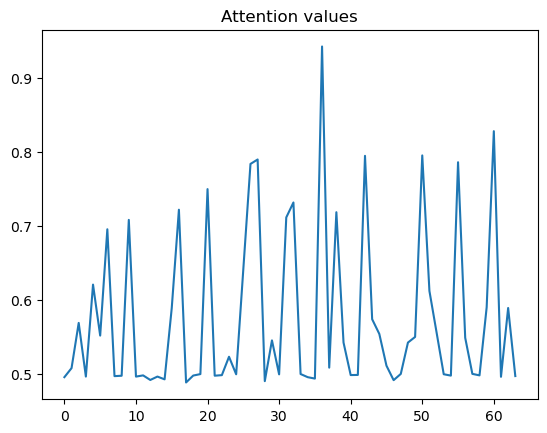

In [48]:
plt.plot(F.sigmoid(channel1_attention).detach())
plt.title('Attention values')
plt.show()

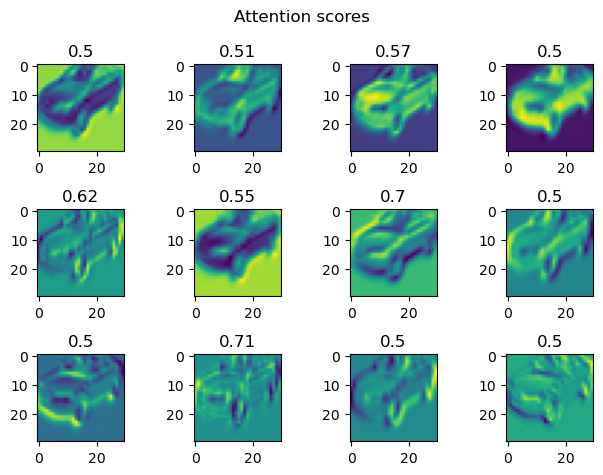

In [51]:
fig,axs=plt.subplots(3,4)
for i in range(3*4):
    axs[i//4][i%4].imshow(conv1_output[i].detach())
    axs[i//4][i%4].set_title(round(F.sigmoid(channel1_attention[i]).item(),2))
plt.suptitle("Attention scores")
plt.tight_layout()

In [61]:
print(torch.argmax(object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))),torch.argmin(object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))))

tensor(36) tensor(17)


In [62]:
F.sigmoid(torch.max(object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))))

tensor(0.9423, grad_fn=<SigmoidBackward0>)

In [66]:
F.sigmoid(torch.min(object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))))

tensor(0.4880, grad_fn=<SigmoidBackward0>)

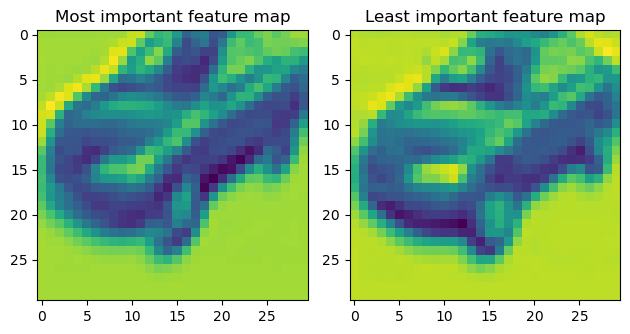

In [68]:
fig,axs=plt.subplots(1,2)
axs[0].imshow(torch.mul(0.9423,conv1_output[36]).detach())
axs[0].set_title("Most important feature map")
axs[1].imshow(torch.mul(0.4880,conv1_output[17]).detach())
axs[1].set_title("Least important feature map")
plt.tight_layout()

In [126]:
maxpool=nn.MaxPool3d(kernel_size=(64,1,1),stride=(64,1,1))
avgpool=nn.AvgPool3d(kernel_size=(64,1,1),stride=(64,1,1))

In [70]:
convolve1=object.convolution1(train_image[24990:24992])

In [71]:
convolve1.shape

torch.Size([2, 64, 30, 30])

In [72]:
spatial1_output=object.spatial_block1.convolution(torch.cat([maxpool(object.convolution1(train_image[24990:24992]))[1],avgpool(object.convolution1(train_image[24990:24992]))[1]],dim=0))

In [73]:
spatial1_output.shape

torch.Size([1, 30, 30])

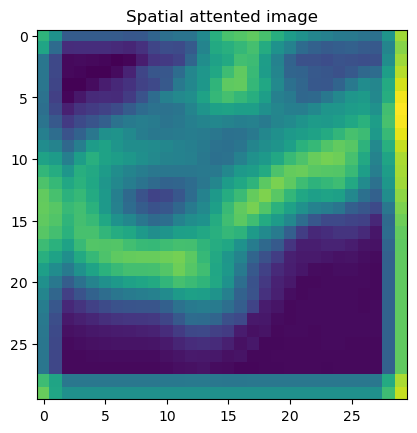

In [74]:
plt.imshow(spatial1_output.permute(1,2,0).detach())
plt.title("Spatial attented image")
plt.show()

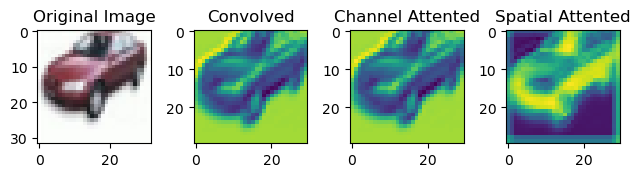

In [56]:
fig,axs=plt.subplots(1,4,width_ratios=[0.25,0.25,0.25,0.25])
axs[0].imshow(train_image[24991].permute(1,2,0).detach())
axs[0].set_title("Original Image")
axs[1].imshow(conv1_output[36].detach())
axs[1].set_title("Convolved")
plt.tight_layout()
axs[2].imshow(torch.mul(0.9423,conv1_output[36]).detach())
axs[2].set_title("Channel Attented")
plt.tight_layout()
axs[3].imshow(torch.mul(spatial1_output[0],maxpool(convolve1)[1][0]).detach())
axs[3].set_title("Spatial Attented")
plt.tight_layout()

It can be clearly seen that spatial attented one actually brightens up the important part and darkens the unimportant part so that when flattened into input layer of ann the weighted sum of these particular pixel will be zero and hence no effect on the result.

In [159]:
conv1_output=object.convolution1.forward(train_image[100])

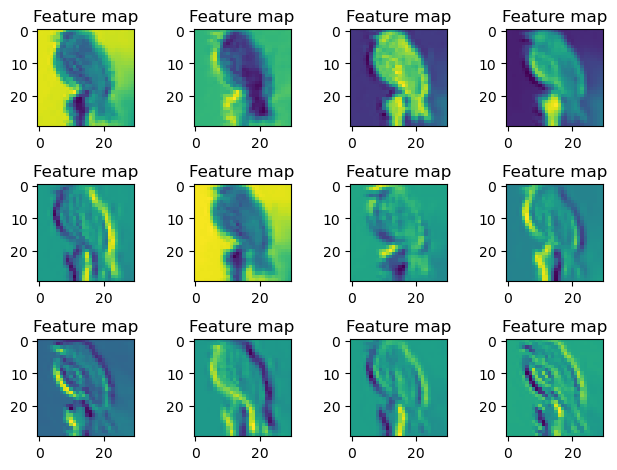

In [160]:
fig,axs=plt.subplots(3,4)
for i in range(3*4):
    axs[i//4][i%4].imshow(conv1_output[i].detach())
    axs[i//4][i%4].set_title("Feature map")
    #plt.tight_layout()
plt.tight_layout()

In [161]:
pool1=F.max_pool2d(conv1_output,kernel_size=(30,30)).reshape(64)
pool2=F.avg_pool2d(conv1_output,kernel_size=(30,30)).reshape(64)

In [162]:
channel1_attention=object.channel_block1.output(object.channel_block1.input(pool1))+object.channel_block1.output(object.channel_block1.input(pool2))

In [163]:
channel1_attention.shape

torch.Size([64])

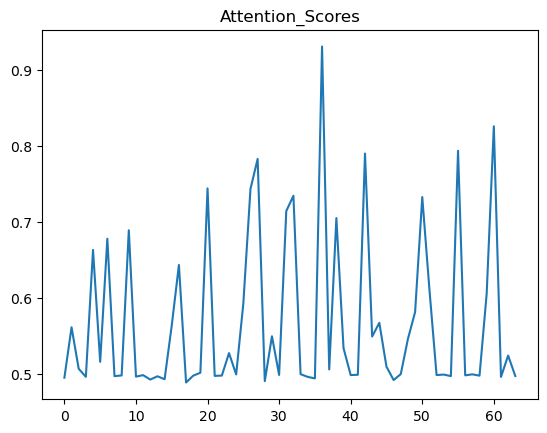

In [164]:
plt.plot(F.sigmoid(channel1_attention).detach())
plt.title("Attention_Scores")
plt.show()

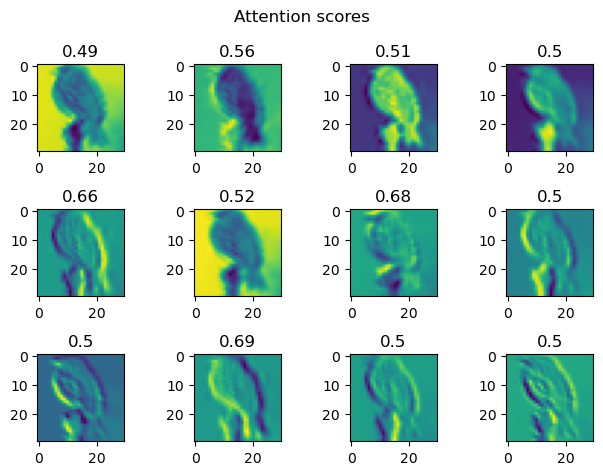

In [165]:
fig,axs=plt.subplots(3,4)
for i in range(3*4):
    axs[i//4][i%4].imshow(conv1_output[i].detach())
    axs[i//4][i%4].set_title(round(F.sigmoid(channel1_attention[i]).item(),2))
plt.suptitle("Attention scores")
plt.tight_layout()

In [174]:
conv1_output[36].shape

torch.Size([30, 30])

Text(0.5, 1.0, 'Least Important Feature')

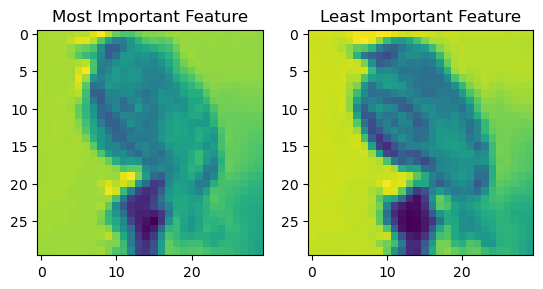

In [176]:
fig,axs=plt.subplots(1,2)
axs[0].imshow(conv1_output[torch.argmax(channel1_attention)].detach())
axs[0].set_title("Most Important Feature")
axs[1].imshow(conv1_output[torch.argmin(channel1_attention)].detach())
axs[1].set_title("Least Important Feature")

In [166]:
maxpool=nn.MaxPool3d(kernel_size=(64,1,1),stride=(64,1,1))
avgpool=nn.AvgPool3d(kernel_size=(64,1,1),stride=(64,1,1))

In [167]:
convolve1=object.convolution1(train_image[99:101])

In [168]:
spatial1_output=object.spatial_block1.convolution(torch.cat([maxpool(object.convolution1(train_image[99:101]))[1],avgpool(object.convolution1(train_image[99:101]))[1]],dim=0))

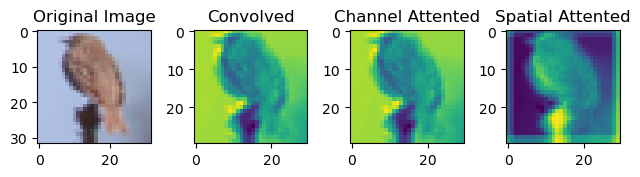

In [177]:
fig,axs=plt.subplots(1,4,width_ratios=[0.25,0.25,0.25,0.25])
axs[0].imshow(train_image[100].permute(1,2,0).detach())
axs[0].set_title("Original Image")
axs[1].imshow(conv1_output[36].detach())
axs[1].set_title("Convolved")
plt.tight_layout()
axs[2].imshow(torch.mul(F.sigmoid(torch.max(channel1_attention)),conv1_output[torch.argmax(channel1_attention)]).detach())
axs[2].set_title("Channel Attented")
plt.tight_layout()
axs[3].imshow(torch.mul(spatial1_output[0],maxpool(convolve1)[1][0]).detach())
axs[3].set_title("Spatial Attented")
plt.tight_layout()

Again we can see that spatial attentiion had blackened the background and has kept only the important part brithen.This shows the model is capable of knowing where the important part is.